K-MEANS CLUSTERING PARA ANÁLISIS DE ENFERMEDADES DE CEBOLLA

In [3]:
#Importar Librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


#Librerias para guardar archivos
import joblib
from pathlib import Path
out_dir = Path.cwd() / "K-Means" #Carpeta para guardar y cargar los modelos de K-means
out_dir.mkdir(parents=True, exist_ok=True)

Función para Cargar los datos desde el CSV

In [2]:
def cargar_datos_desde_csv(csv_path='onion_dataset.csv', tamano_imagen=(32, 32)):
    """
    Carga las imágenes desde el CSV y las convierte a vectores de características.
    """
    
    print("="*60)
    print("CARGANDO DATASET")
    print("="*60)
    
    df = pd.read_csv(csv_path)
    print(f"Archivo CSV cargado: {len(df)} imágenes encontradas")
    
    clases_unicas = df['class'].unique()
    print(f"Clases encontradas: {len(clases_unicas)}")
    for i, clase in enumerate(clases_unicas, 1):
        print(f"   {i}. {clase}")
    
    X = []
    y = []
    errores = 0
    
    print(f"\nProcesando imágenes (tamaño: {tamano_imagen})...")
    
    for idx, fila in df.iterrows():
        try:
            imagen = Image.open(fila['image_path'])
            
            if imagen.mode != 'RGB':
                imagen = imagen.convert('RGB')
            
            imagen = imagen.resize(tamano_imagen)
            imagen_array = np.array(imagen).flatten()
            imagen_normalizada = imagen_array / 255.0
            
            X.append(imagen_normalizada)
            y.append(fila['class'])
            
            if (idx + 1) % 100 == 0:
                print(f"   Procesadas: {idx + 1}/{len(df)}")
                
        except Exception as e:
            errores += 1
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"\nProcesamiento completado")
    print(f"   Imágenes procesadas: {len(X)}")
    print(f"   Errores: {errores}")
    print(f"   Forma de X: {X.shape}")
    
    return X, y, clases_unicas

Función para entrenar Modelo

In [3]:
def entrenar_kmeans(X_train, n_clusters=15, random_state=42):
    """
    Entrena un modelo de K-Means.
    """
    
    print("\n" + "="*60)
    print("ENTRENANDO K-MEANS")
    print("="*60)
    
    modelo = KMeans(
        n_clusters=n_clusters,
        random_state=random_state,
        n_init=10,
        max_iter=300
    )
    
    print(f"Entrenando con {n_clusters} clusters...")
    modelo.fit(X_train)
    
    print("Modelo entrenado")
    print(f"   Iteraciones realizadas: {modelo.n_iter_}")
    print(f"   Inercia: {modelo.inertia_:.4f}")
    
    return modelo

Función para mapear clusers a clases

In [4]:
def mapear_clusters_a_clases(clusters, etiquetas_reales):
    """
    Mapea cada cluster al label más frecuente en ese cluster.
    """
    
    mapeo = {}
    clusters_unicos = np.unique(clusters)
    
    for cluster_id in clusters_unicos:
        mask = clusters == cluster_id
        etiquetas_cluster = etiquetas_reales[mask]
        if len(etiquetas_cluster) > 0:
            etiqueta_mas_comun = mode(etiquetas_cluster)[0]
            mapeo[cluster_id] = etiqueta_mas_comun
        else:
            mapeo[cluster_id] = 0
    
    return mapeo


Función para evaluar el desempeño del modelo

In [5]:
def evaluar_clustering(modelo, X_test, y_test, X_train, y_train, nombres_clases, label_encoder):
    """
    Evalúa el modelo de clustering y muestra métricas.
    """
    
    print("\n" + "="*60)
    print("EVALUACIÓN DEL MODELO K-MEANS")
    print("="*60)
    
    # Predecir clusters para datos de entrenamiento y prueba
    clusters_train = modelo.predict(X_train)
    clusters_test = modelo.predict(X_test)
    
    # Mapear clusters a clases usando datos de entrenamiento
    mapeo = mapear_clusters_a_clases(clusters_train, y_train)
    
    print("\nMapeo de clusters a clases:")
    for cluster_id, clase_id in mapeo.items():
        print(f"   Cluster {cluster_id} -> Clase {clase_id} ({nombres_clases[clase_id]})")
    
    # Convertir predicciones de cluster a predicciones de clase
    y_pred = np.array([mapeo[cluster] for cluster in clusters_test])
    
    # Calcular accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Calcular silhouette score
    if len(X_test) < 10000:  # Para evitar problemas de memoria
        silhouette = silhouette_score(X_test, clusters_test)
        print(f"Silhouette Score: {silhouette:.4f}")
    
    # Distribución de clusters
    print(f"\nDistribución de clusters en test:")
    valores_unicos, conteos = np.unique(clusters_test, return_counts=True)
    for val, count in zip(valores_unicos, conteos):
        print(f"   Cluster {val}: {count} muestras")
    
    # Reporte de clasificación
    print("\nREPORTE DETALLADO POR CLASE:")
    print("-"*60)
    
    y_test_decoded = label_encoder.inverse_transform(y_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    
    reporte = classification_report(y_test_decoded, y_pred_decoded, 
                                   target_names=nombres_clases, 
                                   zero_division=0)
    print(reporte)
    
    # Matriz de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)
    
    return accuracy, y_pred, matriz_confusion, clusters_test

In [6]:


def visualizar_matriz_confusion(matriz_confusion, nombres_clases):
    """
    Visualiza la matriz de confusión de K-Means.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(matriz_confusion, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=nombres_clases,
                yticklabels=nombres_clases,
                cbar=True)
    plt.title('Matriz de Confusión - K-Means', fontsize=14)
    plt.ylabel('Clase Real', fontsize=12)
    plt.xlabel('Clase Predicha (vía mapeo de clusters)', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.savefig(out_dir/'matriz_confusion_kmeans.png', dpi=100, bbox_inches='tight')
    plt.show()


def visualizar_distribucion_clusters(clusters_test):
    """
    Visualiza la distribución de muestras por cluster.
    """
    plt.figure(figsize=(10, 6))
    cluster_counts = np.bincount(clusters_test)
    bars = plt.bar(range(len(cluster_counts)), cluster_counts, color='steelblue', edgecolor='black')
    
    # Agregar valores en las barras
    for bar, count in zip(bars, cluster_counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}', ha='center', va='bottom')
    
    plt.xlabel('Cluster ID', fontsize=12)
    plt.ylabel('Número de Muestras', fontsize=12)
    plt.title('Distribución de Muestras por Cluster', fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(out_dir/'distribucion_clusters_kmeans.png', dpi=100, bbox_inches='tight')
    plt.show()


def visualizar_pureza_clusters(clusters_test, y_test):
    """
    Visualiza la pureza de cada cluster.
    """
    plt.figure(figsize=(10, 6))
    n_clusters = len(np.unique(clusters_test))
    pureza_clusters = []
    clases_dominantes = []
    
    for cluster_id in range(n_clusters):
        mask = clusters_test == cluster_id
        if np.sum(mask) > 0:
            labels_en_cluster = y_test[mask]
            valores, conteos = np.unique(labels_en_cluster, return_counts=True)
            pureza = np.max(conteos) / np.sum(conteos) if len(conteos) > 0 else 0
            pureza_clusters.append(pureza)
            clase_dominante = valores[np.argmax(conteos)]
            clases_dominantes.append(clase_dominante)
        else:
            pureza_clusters.append(0)
            clases_dominantes.append(-1)
    
    bars = plt.bar(range(len(pureza_clusters)), pureza_clusters, color='coral', edgecolor='black')
    
    # Agregar porcentajes en las barras
    for bar, pureza in zip(bars, pureza_clusters):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{pureza:.1%}', ha='center', va='bottom')
    
    plt.xlabel('Cluster ID', fontsize=12)
    plt.ylabel('Pureza (% de clase dominante)', fontsize=12)
    plt.title('Pureza de Clusters', fontsize=14)
    plt.ylim([0, 1.1])
    plt.grid(True, alpha=0.3, axis='y')
    
    # Línea horizontal en 0.5 para referencia
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% pureza')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(out_dir/'pureza_clusters_kmeans.png', dpi=100, bbox_inches='tight')
    plt.show()

def analisis_elbow(X, max_k=20):
    """
    Realiza análisis de codo para determinar número óptimo de clusters.
    """
    
    print("\n" + "="*60)
    print("ANÁLISIS DE CODO (ELBOW METHOD)")
    print("="*60)
    
    inercias = []
    K_range = range(2, min(max_k + 1, len(np.unique(X, axis=0))))
    
    print("Calculando inercias para diferentes valores de K...")
    for k in K_range:
        kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=5)
        kmeans_temp.fit(X)
        inercias.append(kmeans_temp.inertia_)
        print(f"   K={k}: Inercia={kmeans_temp.inertia_:.2f}")
    
    # Graficar
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inercias, 'bo-')
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Inercia')
    plt.title('Método del Codo - Selección de K Óptimo')
    plt.grid(True, alpha=0.3)
    
    # Marcar el K actual (15 clases conocidas)
    if 15 in K_range:
        idx_15 = list(K_range).index(15)
        plt.plot(15, inercias[idx_15], 'ro', markersize=10, label='K=15 (clases reales)')
        plt.legend()
    
    plt.savefig(out_dir/'elbow_analysis.png', dpi=100)
    print("\nGráfico de codo guardado como 'elbow_analysis.png'")
    plt.show()


Función para predecir una nueva imagen

In [4]:
def predecir_imagen(ruta_imagen, modelo_path=out_dir/'modelo_kmeans.pkl'):
    """
    Predice la clase de una nueva imagen usando el modelo K-Means entrenado
    y muestra la imagen con el label (según mapeo fijo) en el título.
    """
    import joblib
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt

    try:
        # --- Mapeo fijo cluster -> label (según tu lista) ---
        labels = [
            "Alternaria_D",
            "Botrytis Leaf Blight",
            "Bulb Rot",
            "Bulb_blight-D",
            "Caterpillar-P",
            "Downy mildew",
            "Fusarium-D",
            "Healthy leaves",
            "Iris yellow virus_augment",
            "Purple blotch",
            "Rust",
            "Virosis-D",
            "Xanthomonas Leaf Blight",
            "onion1",
            "stemphylium Leaf Blight",
        ]
        # Soporta cluster IDs 0-based y 1-based
        map_zero = {i: labels[i] for i in range(len(labels))}          # 0..14
        map_one  = {i+1: labels[i] for i in range(len(labels))}        # 1..15

        # --- Cargar modelo y scaler ---
        print("\nCargando modelo y transformadores...")
        modelo = joblib.load(modelo_path)
        scaler = joblib.load(out_dir/'scaler_kmeans.pkl')

        print(f"Procesando imagen: {ruta_imagen}")

        # Cargar imagen original para visualizar
        imagen_viz = Image.open(ruta_imagen)
        if imagen_viz.mode != 'RGB':
            imagen_viz = imagen_viz.convert('RGB')

        # Procesar imagen para el modelo (mismo tamaño que entrenamiento)
        imagen_proc = imagen_viz.resize((32, 32))
        imagen_array = np.array(imagen_proc).flatten() / 255.0
        imagen_array = imagen_array.reshape(1, -1)

        # Escalar
        imagen_scaled = scaler.transform(imagen_array)

        # Predecir cluster
        cluster_predicho = modelo.predict(imagen_scaled)[0]

        # Calcular distancias a todos los centroides
        distancias = modelo.transform(imagen_scaled)[0]
        distancia_minima = distancias[cluster_predicho]

        print(f"\nPREDICCIÓN:")
        print(f"   Cluster asignado: {cluster_predicho}")
        print(f"   Distancia al centroide: {distancia_minima:.4f}")

        # Clusters más cercanos
        indices_ordenados = np.argsort(distancias)
        print(f"\nClusters más cercanos (por distancia):")
        for i in range(min(3, len(indices_ordenados))):
            idx = indices_ordenados[i]
            print(f"   {i+1}. Cluster {idx}: distancia = {distancias[idx]:.4f}")

        # --- Determinar label de visualización (switch) ---
        if cluster_predicho in map_zero:
            label_text = map_zero[cluster_predicho]
        elif cluster_predicho in map_one:
            label_text = map_one[cluster_predicho]
        else:
            # Fallback por si el ID no coincide con 0..14 ni 1..15
            label_text = f"Cluster {cluster_predicho}"

        # --- Visualización ---
        plt.figure()
        plt.imshow(imagen_viz)
        plt.axis('off')
        plt.title(f"Predicción: {label_text}")
        plt.show()

        return cluster_predicho

    except FileNotFoundError:
        print("ERROR: No se encontraron los archivos del modelo/scaler.")
        return None
    except Exception as e:
        print(f"ERROR al procesar la imagen: {e}")
        return None



Parametros del Modelo

In [8]:
CSV_PATH = 'onion_dataset.csv'
TAMANO_IMAGEN = (32, 32)
TEST_SIZE = 0.2
N_CLUSTERS = 15  # Número de clases conocidas

In [9]:
 # 1. Cargar datos
X, y, clases_unicas = cargar_datos_desde_csv(CSV_PATH, TAMANO_IMAGEN)

CARGANDO DATASET
Archivo CSV cargado: 13229 imágenes encontradas
Clases encontradas: 15
   1. Alternaria_D
   2. Botrytis Leaf Blight
   3. Bulb Rot
   4. Bulb_blight-D
   5. Caterpillar-P
   6. Downy mildew
   7. Fusarium-D
   8. Healthy leaves
   9. Iris yellow virus_augment
   10. Purple blotch
   11. Rust
   12. Virosis-D
   13. Xanthomonas Leaf Blight
   14. onion1
   15. stemphylium Leaf Blight

Procesando imágenes (tamaño: (32, 32))...
   Procesadas: 100/13229
   Procesadas: 200/13229
   Procesadas: 300/13229
   Procesadas: 400/13229
   Procesadas: 500/13229
   Procesadas: 600/13229
   Procesadas: 700/13229
   Procesadas: 800/13229
   Procesadas: 900/13229
   Procesadas: 1000/13229
   Procesadas: 1100/13229
   Procesadas: 1200/13229
   Procesadas: 1300/13229
   Procesadas: 1400/13229
   Procesadas: 1500/13229
   Procesadas: 1600/13229
   Procesadas: 1700/13229
   Procesadas: 1800/13229
   Procesadas: 1900/13229
   Procesadas: 2000/13229
   Procesadas: 2100/13229
   Procesadas: 2

In [10]:
# 2. Codificar etiquetas
print("\nCodificando etiquetas...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


Codificando etiquetas...


In [11]:
# 3. Dividir en entrenamiento y prueba
print("\nDividiendo datos...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=42,
    stratify=y_encoded
    )
print(f"   Entrenamiento: {len(X_train)} imágenes")
print(f"   Prueba: {len(X_test)} imágenes")


Dividiendo datos...
   Entrenamiento: 10583 imágenes
   Prueba: 2646 imágenes


In [12]:
# 4. Escalar características
print("\nEscalando características...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Escalando características...



ANÁLISIS DE CODO (ELBOW METHOD)
Calculando inercias para diferentes valores de K...
   K=2: Inercia=2540738.95
   K=3: Inercia=2370868.22
   K=4: Inercia=2282569.81
   K=5: Inercia=2226325.02
   K=6: Inercia=2184333.17
   K=7: Inercia=2146279.08
   K=8: Inercia=2122818.60
   K=9: Inercia=2102345.68
   K=10: Inercia=2077134.80
   K=11: Inercia=2054139.77
   K=12: Inercia=2043090.56
   K=13: Inercia=2034277.59
   K=14: Inercia=2021638.15
   K=15: Inercia=2009979.57
   K=16: Inercia=1996387.72
   K=17: Inercia=1993097.74
   K=18: Inercia=1968389.51
   K=19: Inercia=1962102.43
   K=20: Inercia=1955674.39

Gráfico de codo guardado como 'elbow_analysis.png'


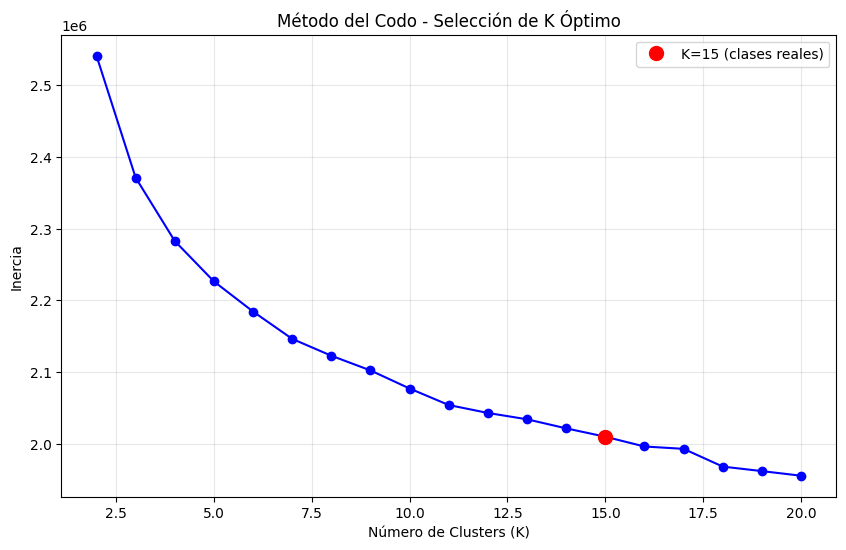

In [13]:
# 5. Análisis de codo para dederminar numero de clusters optimo
analisis_elbow(X_train_scaled[:1000], max_k=20)
        

In [14]:
# 6. Entrenar K-Means
modelo = entrenar_kmeans(X_train_scaled, n_clusters=N_CLUSTERS)


ENTRENANDO K-MEANS
Entrenando con 15 clusters...
Modelo entrenado
   Iteraciones realizadas: 78
   Inercia: 21502144.3180


In [23]:
# 7. Evaluar modelo
accuracy, y_pred, matriz, clusters_test = evaluar_clustering(
    modelo, 
    X_test_scaled, 
    y_test,
    X_train_scaled,
    y_train,
    label_encoder.classes_,
    label_encoder
)


EVALUACIÓN DEL MODELO K-MEANS

Mapeo de clusters a clases:
   Cluster 0 -> Clase [7] (['Healthy leaves'])
   Cluster 1 -> Clase [4] (['Caterpillar-P'])
   Cluster 2 -> Clase [14] (['stemphylium Leaf Blight'])
   Cluster 3 -> Clase [8] (['Iris yellow virus_augment'])
   Cluster 4 -> Clase [7] (['Healthy leaves'])
   Cluster 5 -> Clase [1] (['Botrytis Leaf Blight'])
   Cluster 6 -> Clase [7] (['Healthy leaves'])
   Cluster 7 -> Clase [7] (['Healthy leaves'])
   Cluster 8 -> Clase [7] (['Healthy leaves'])
   Cluster 9 -> Clase [4] (['Caterpillar-P'])
   Cluster 10 -> Clase [7] (['Healthy leaves'])
   Cluster 11 -> Clase [7] (['Healthy leaves'])
   Cluster 12 -> Clase [1] (['Botrytis Leaf Blight'])
   Cluster 13 -> Clase [0] (['Alternaria_D'])
   Cluster 14 -> Clase [7] (['Healthy leaves'])

ACCURACY: 0.3039 (30.39%)
Silhouette Score: 0.0321

Distribución de clusters en test:
   Cluster 0: 213 muestras
   Cluster 1: 189 muestras
   Cluster 2: 68 muestras
   Cluster 3: 233 muestras
   Clus

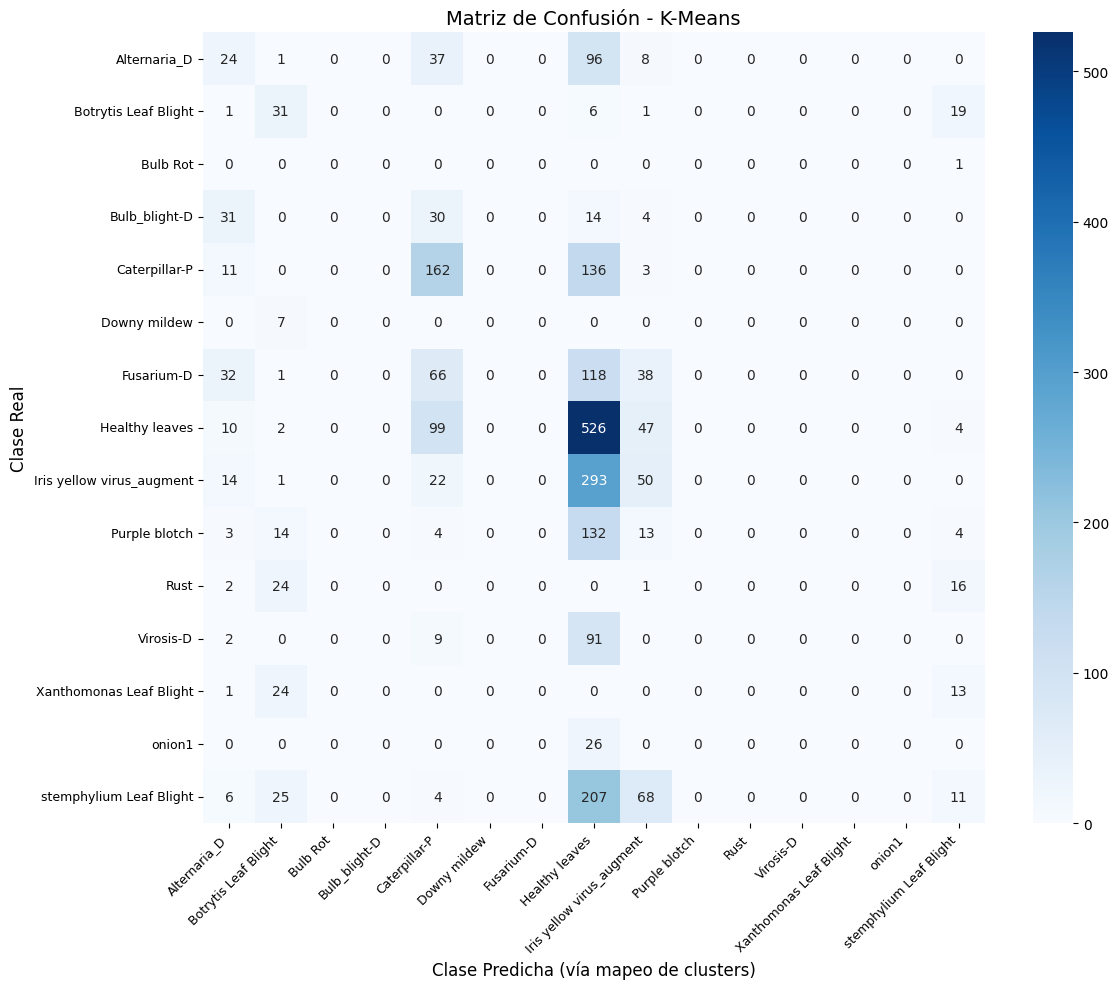

In [16]:
#Visualizar matriz de confusion
visualizar_matriz_confusion(matriz,label_encoder.classes_)

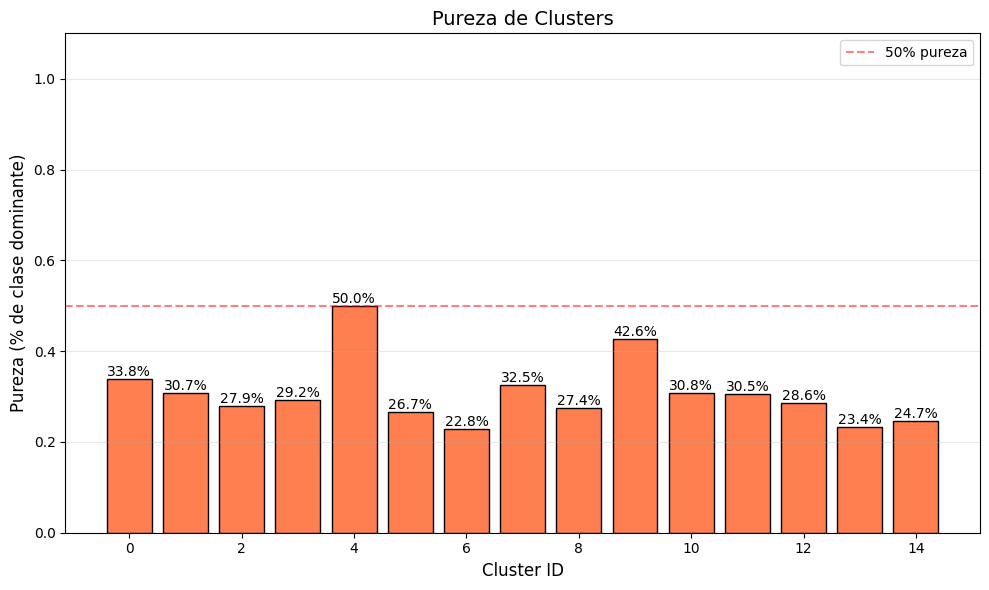

In [17]:
visualizar_pureza_clusters(clusters_test,y_test)

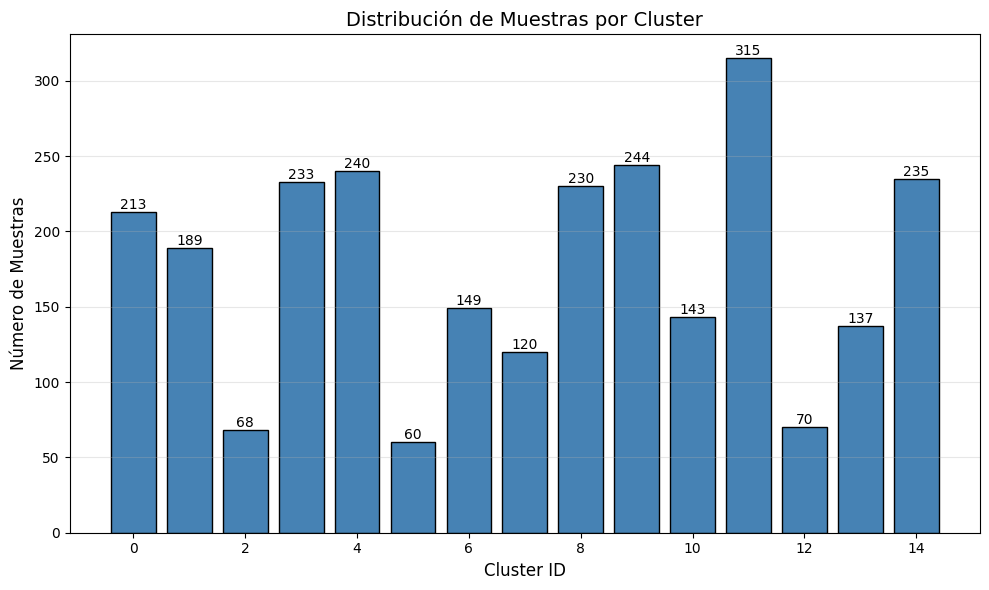

In [18]:
visualizar_distribucion_clusters(clusters_test)

In [19]:
# 9. Guardar modelo
joblib.dump(modelo, out_dir/'modelo_kmeans.pkl')
joblib.dump(scaler, out_dir/'scaler_kmeans.pkl')
joblib.dump(label_encoder, out_dir/'label_encoder_kmeans.pkl')
print("\nModelo guardado como 'modelo_kmeans.pkl'")


Modelo guardado como 'modelo_kmeans.pkl'


In [20]:
# 10. Análisis por clase
print("\n" + "="*60)
print("ANÁLISIS DE RENDIMIENTO POR CLASE")
print("="*60)
accuracies_por_clase = matriz.diagonal() / (matriz.sum(axis=1) + 1e-10)
for i, clase in enumerate(label_encoder.classes_):
    acc_clase = accuracies_por_clase[i]
    total_clase = matriz.sum(axis=1)[i]
    correctas = matriz.diagonal()[i]
    print(f"{clase:30s}: {acc_clase:6.2%} accuracy ({correctas}/{total_clase} correctas)")


ANÁLISIS DE RENDIMIENTO POR CLASE
Alternaria_D                  : 14.46% accuracy (24/166 correctas)
Botrytis Leaf Blight          : 53.45% accuracy (31/58 correctas)
Bulb Rot                      :  0.00% accuracy (0/1 correctas)
Bulb_blight-D                 :  0.00% accuracy (0/79 correctas)
Caterpillar-P                 : 51.92% accuracy (162/312 correctas)
Downy mildew                  :  0.00% accuracy (0/7 correctas)
Fusarium-D                    :  0.00% accuracy (0/255 correctas)
Healthy leaves                : 76.45% accuracy (526/688 correctas)
Iris yellow virus_augment     : 13.16% accuracy (50/380 correctas)
Purple blotch                 :  0.00% accuracy (0/170 correctas)
Rust                          :  0.00% accuracy (0/43 correctas)
Virosis-D                     :  0.00% accuracy (0/102 correctas)
Xanthomonas Leaf Blight       :  0.00% accuracy (0/38 correctas)
onion1                        :  0.00% accuracy (0/26 correctas)
stemphylium Leaf Blight       :  3.43% accu


Cargando modelo y transformadores...
Procesando imagen: Imagenes_Prueba/Alternaria.jpg

PREDICCIÓN:
   Cluster asignado: 11
   Distancia al centroide: 50.7828

Clusters más cercanos (por distancia):
   1. Cluster 11: distancia = 50.7828
   2. Cluster 6: distancia = 52.2399
   3. Cluster 9: distancia = 52.7645


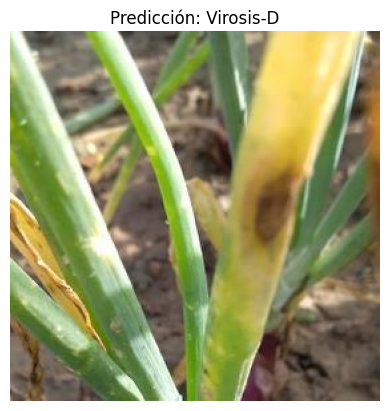

11

In [21]:
predecir_imagen("Imagenes_Prueba/Alternaria.jpg")


Cargando modelo y transformadores...
Procesando imagen: Imagenes_Prueba/Downy.jpg

PREDICCIÓN:
   Cluster asignado: 12
   Distancia al centroide: 39.6657

Clusters más cercanos (por distancia):
   1. Cluster 12: distancia = 39.6657
   2. Cluster 5: distancia = 60.0056
   3. Cluster 4: distancia = 60.8272


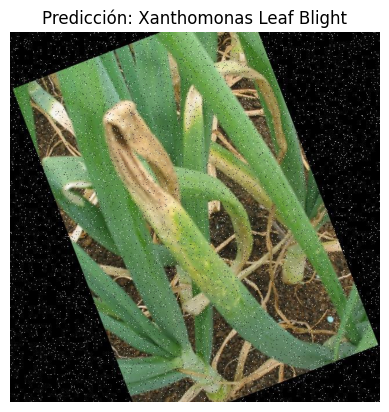

12

In [5]:
predecir_imagen("Imagenes_Prueba/Downy.jpg")


Cargando modelo y transformadores...
Procesando imagen: Imagenes_Prueba/Iris.jpg

PREDICCIÓN:
   Cluster asignado: 10
   Distancia al centroide: 48.5584

Clusters más cercanos (por distancia):
   1. Cluster 10: distancia = 48.5584
   2. Cluster 9: distancia = 51.2371
   3. Cluster 11: distancia = 56.8407


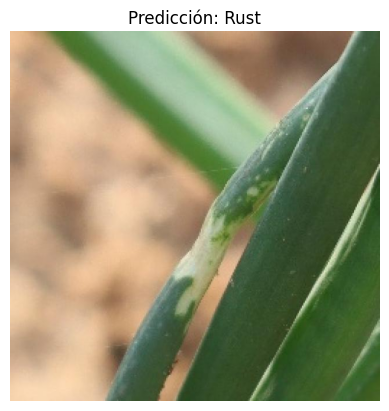

10

In [6]:
predecir_imagen("Imagenes_Prueba/Iris.jpg")


Cargando modelo y transformadores...
Procesando imagen: Imagenes_Prueba/Purple.jpg

PREDICCIÓN:
   Cluster asignado: 4
   Distancia al centroide: 42.1019

Clusters más cercanos (por distancia):
   1. Cluster 4: distancia = 42.1019
   2. Cluster 0: distancia = 50.5128
   3. Cluster 3: distancia = 50.5963


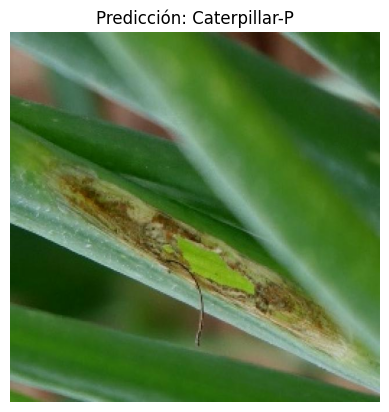

4

In [7]:
predecir_imagen("Imagenes_Prueba/Purple.jpg")